In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/ajc348/rds/hpc-work/mopo')

In [3]:
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dogo.results import get_sac_pools, get_experiment_details, PoolArrs
from dogo.rollouts.split import split_halfcheetah_v2_trans_arr
from dogo.visualisation.model_pool_plotting import (
    model_pool_visitation_2dhist,
    model_pool_pen_rewards_2dhist,
    model_pool_unpen_rewards_2dhist,
    model_pool_penalties_2dhist,
    model_pool_rmse_2dhist
)

In [4]:
cols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [9]:
EXP_LIST = [
    # No REx - MOPO Pen 5 - Rollout Length 10 - 1 Retrain Epoch
    "MP862",
    "MP863",
    "MP864",
    # REx 10 - MOPO Pen 5 - Rollout Length 10 - 1 Retrain Epoch
    "MP865",
    "MP866",
    "MP867",
]
SUBSAMPLE_SIZE = None
training_results = {}
for exp in EXP_LIST:
    # print(exp)
    training_results[exp] = PoolArrs(*get_sac_pools(exp, subsample_size=SUBSAMPLE_SIZE))

# Pool Analysis

In [8]:
min_angle = +np.inf
max_angle = -np.inf
for exp in EXP_LIST:
    obs, _, next_obs, _, _, _, _ = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    min_angle = min(min_angle, obs[:,1:8].min())#, next_obs[:,1:8].min())
    max_angle = max(max_angle, obs[:,1:8].max())#, next_obs[:,1:8].max())
min_angle, max_angle

(-3.1415915, 3.1415696)

# Reward Histograms

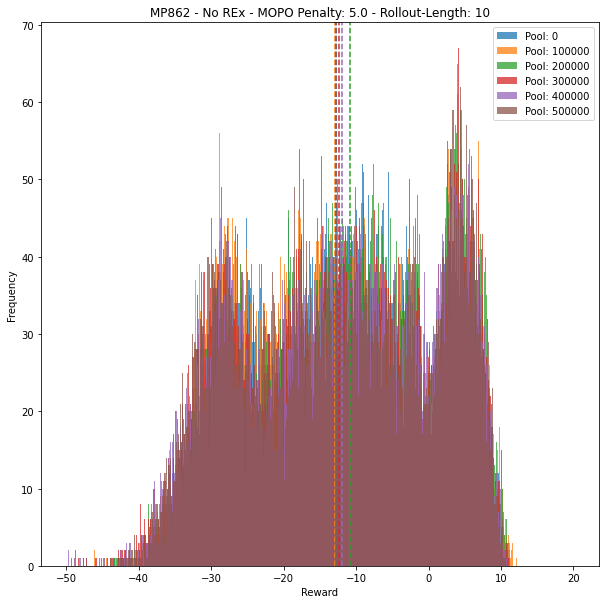

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

exp = 'MP862'
for i, pool_id in enumerate(range(0,600000,100000)):
    pool, _, _, _, _ = get_sac_pools(exp, pool=str(pool_id))
    _, _, _, rew, _, _, _ = split_halfcheetah_v2_trans_arr(pool)
    ax.hist(rew, bins=np.linspace(-50,20,500), color=cols[i], alpha=0.75, label=f'Pool: {pool_id}')
    ax.axvline(rew.mean(), color=cols[i], ls='--')
ax.set_xlabel('Reward')
ax.set_ylabel('Frequency')
ax.set_title(f'{exp} - No REx - MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.legend()

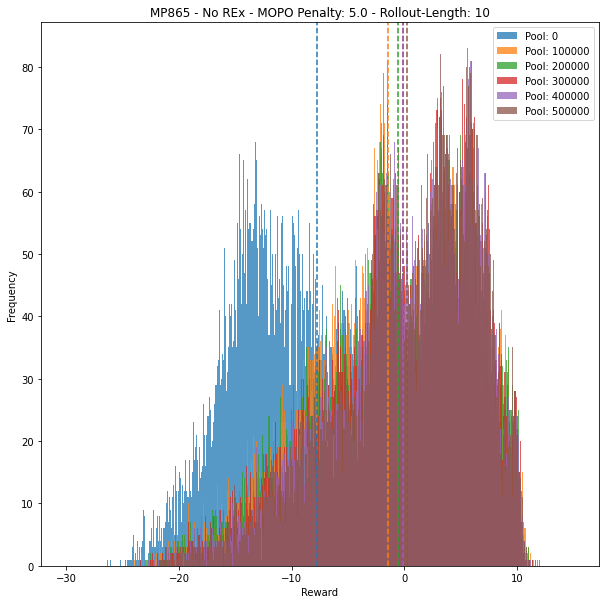

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

exp = 'MP865'
for i, pool_id in enumerate(range(0,600000,100000)):
    pool, _, _, _, _ = get_sac_pools(exp, pool=str(pool_id))
    _, _, _, rew, _, _, _ = split_halfcheetah_v2_trans_arr(pool)
    ax.hist(rew, bins=np.linspace(-30,15,500), color=cols[i], alpha=0.75, label=f'Pool: {pool_id}')
    ax.axvline(rew.mean(), color=cols[i], ls='--')
ax.set_xlabel('Reward')
ax.set_ylabel('Frequency')
ax.set_title(f'{exp} - No REx - MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.legend()

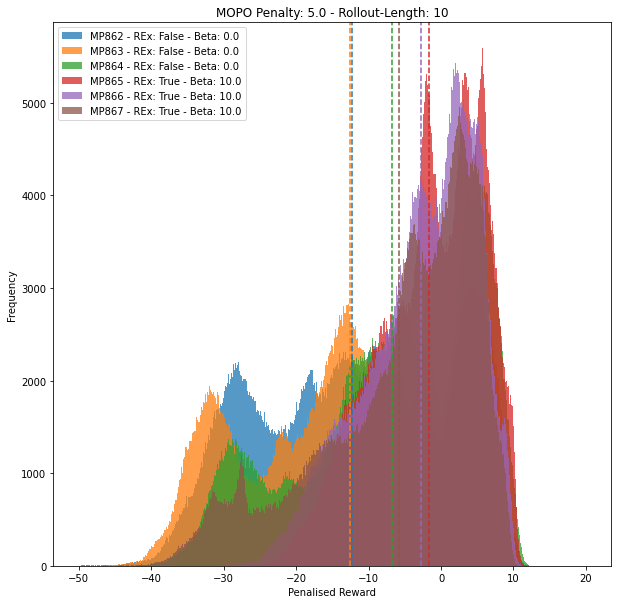

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    _, _, _, rew, _, _, _ = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    ax.hist(rew, bins=np.linspace(-50,20,500), color=cols[i], alpha=0.75, label=f'{exp} - REx: {rex} - Beta: {beta}')
    ax.axvline(rew.mean(), color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Penalised Reward')
ax.set_ylabel('Frequency')
ax.legend(loc='upper left')

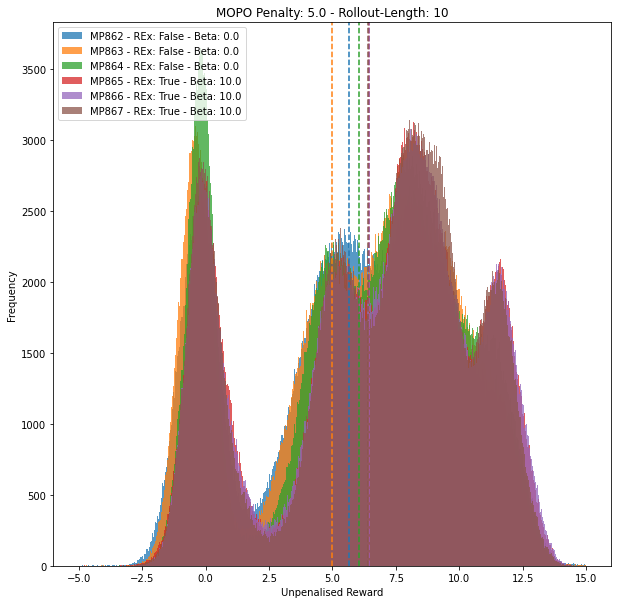

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    _, _, _, rew, _, _, pen = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    ax.hist(rew+5*pen, bins=np.linspace(-5,15,500), color=cols[i], alpha=0.75, label=f'{exp} - REx: {rex} - Beta: {beta}')
    ax.axvline((rew+5*pen).mean(), color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Unpenalised Reward')
ax.set_ylabel('Frequency')
ax.legend(loc='upper left')

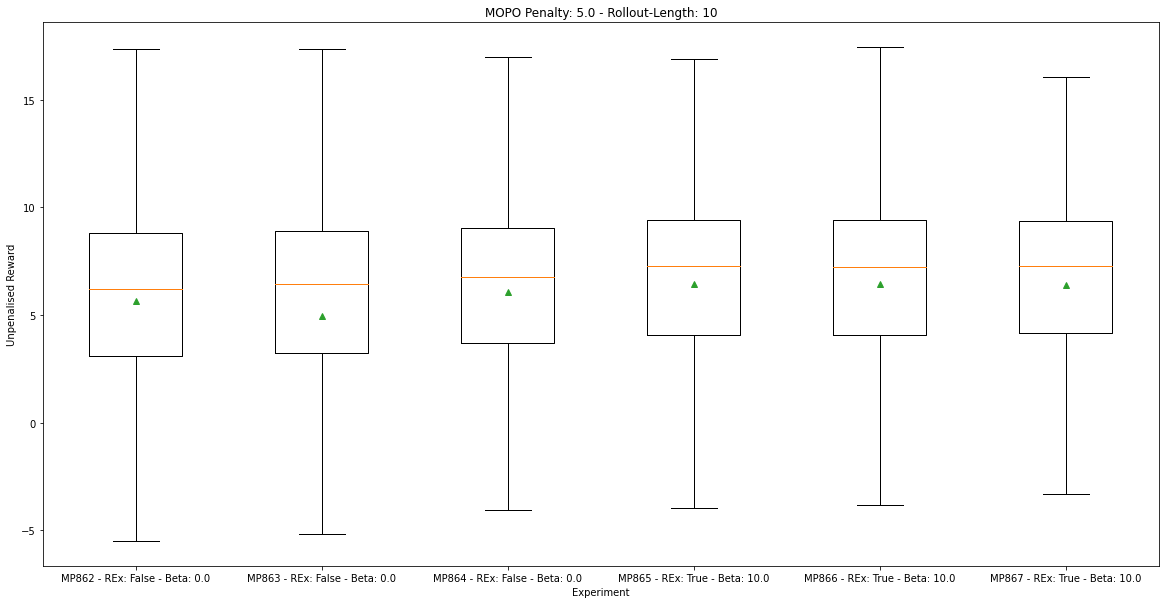

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

labels = []
unpen_rew_arrs = []
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, rew, _, _, pen = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    unpen_rew = (rew+5*pen).flatten()
    unpen_rew_arrs.append(unpen_rew)
    
    labels.append(f'{exp} - REx: {rex} - Beta: {beta}')

x_vals = np.arange(len(unpen_rew_arrs))+1
ax.boxplot(unpen_rew_arrs, showmeans=True, showfliers=False)

ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Experiment')
ax.set_ylabel('Unpenalised Reward')
ax.set_xticks(x_vals)
ax.set_xticklabels(labels)
pass

# Penalty Histograms

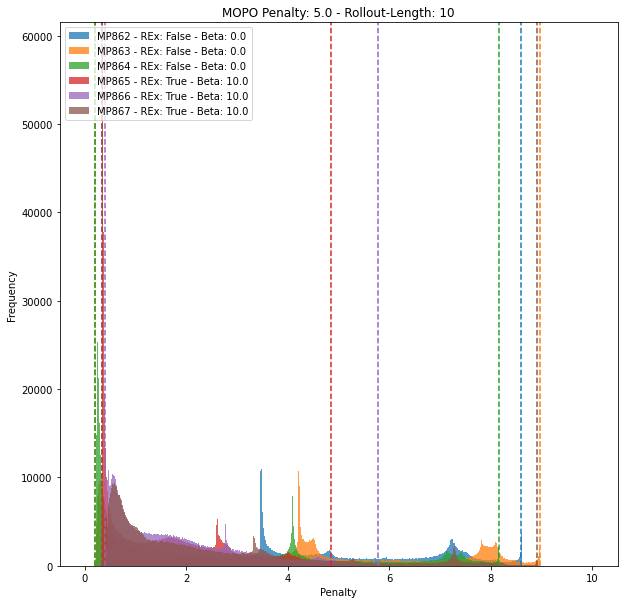

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, _, _, _, pens = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    ax.hist(pens, bins=np.linspace(0,10,500), color=cols[i], alpha=0.75, label=f'{exp} - REx: {rex} - Beta: {beta}')
    ax.axvline(exp_details.min_penalty, color=cols[i], ls='--')
    ax.axvline(exp_details.max_penalty, color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Penalty')
ax.set_ylabel('Frequency')
ax.legend(loc='upper left')

15617
12172
11352
4894
4153
2747


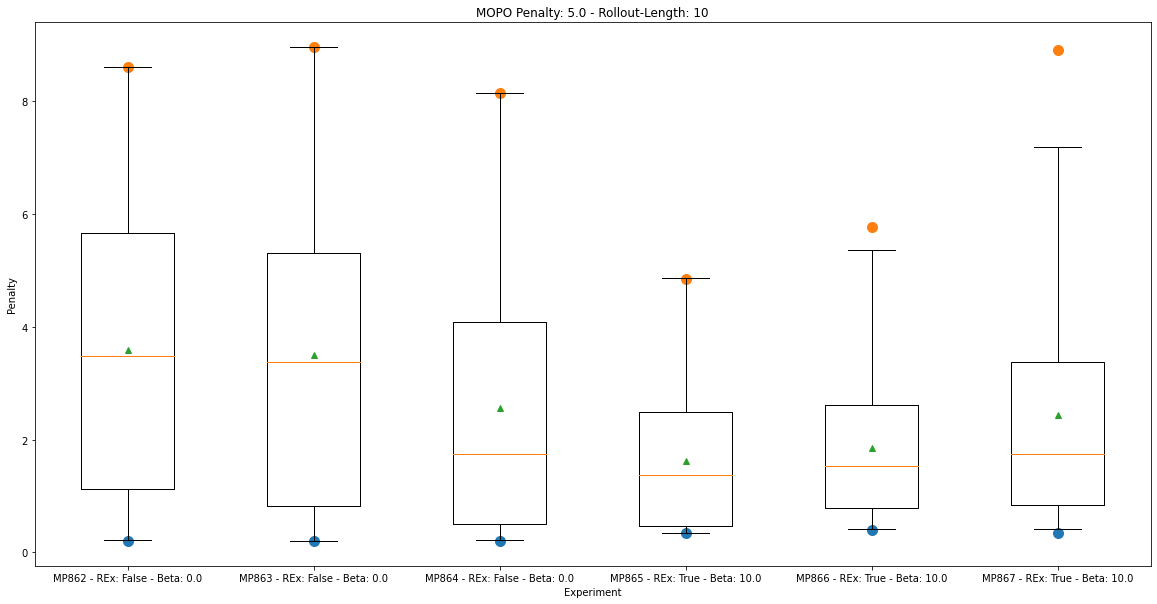

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

labels = []
pens_arrs = []
min_pens = []
max_pens = []
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, _, _, _, pens = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    pens_arrs.append(pens.flatten())
    
    labels.append(f'{exp} - REx: {rex} - Beta: {beta}')
    min_pens.append(exp_details.min_penalty)
    max_pens.append(exp_details.max_penalty)

    print((pens.flatten()>(0.95*exp_details.max_penalty)).sum())

x_vals = np.arange(len(pens_arrs))+1
ax.boxplot(pens_arrs, showmeans=True, showfliers=False)
ax.scatter(x_vals, min_pens, s=100)
ax.scatter(x_vals, max_pens, s=100)

ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Experiment')
ax.set_ylabel('Penalty')
ax.set_xticks(x_vals)
ax.set_xticklabels(labels)
pass

# RMSE Histograms

MP862: nan, nan, nan, nan, nan
MP863: nan, nan, nan, nan, nan
MP864: 2.6483638286590576, 0.04326184466481209, 80250.359375, 132.01168823242188, 9.175811243057234
MP865: 1.7707933187484741, 0.052063822746276855, 141.81771850585938, 2.3077802658081055, 6.146517467498765
MP866: 1.7606762647628784, 0.05258060246706009, 84.95465850830078, 2.2542200088500977, 6.043051362037649


KeyboardInterrupt: 

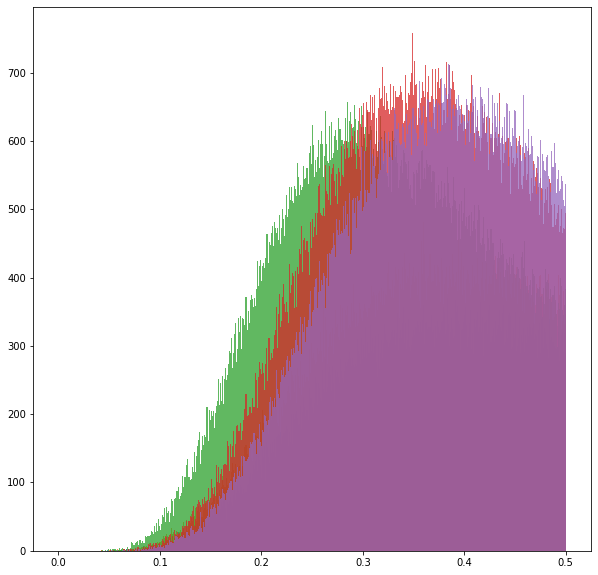

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    rmse_vals = np.sqrt(training_results[exp].mse_results)
    ax.hist(rmse_vals, bins=np.linspace(0,0.5,500), color=cols[i], alpha=0.75, label=f'{exp} - REx: {rex} - Beta: {beta}')
    # ax.axvline(np.nanmean(rmse_vals), color=cols[i], ls='--')
    print(f'{exp}: {rmse_vals.mean()}, {rmse_vals.min()}, {rmse_vals.max()}, {rmse_vals.std()}, {np.quantile(rmse_vals, 0.95)}')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('RMSE')
ax.set_ylabel('Frequency')
ax.legend(loc='upper right')

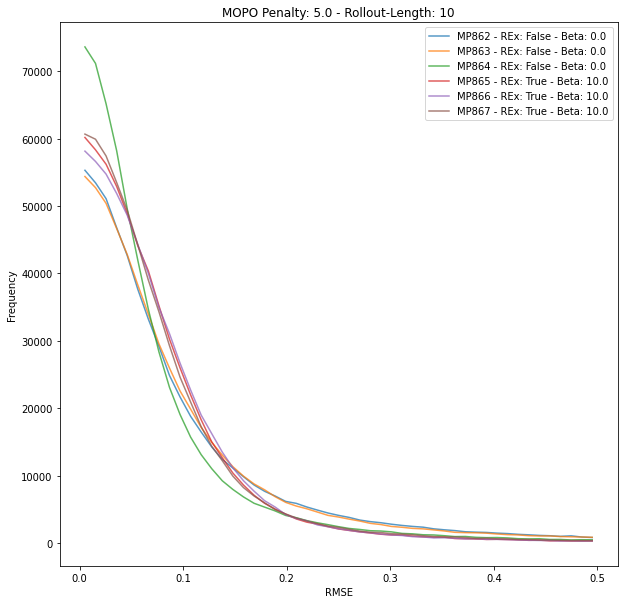

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    bin_min, bin_max, bin_size = 0, 0.5, 50
    bins = np.linspace(bin_min, bin_max, bin_size)
    hist_arr, _ = np.histogram(np.sqrt(training_results[exp].mse_results), bins=bins)

    plt.plot((bins + bin_max/(2*(bin_size-1)))[:-1], hist_arr, color=cols[i], alpha=0.75, label=f'{exp} - REx: {rex} - Beta: {beta}')
    # ax.axvline(np.nanmean(np.sqrt(training_results[exp].mse_results)), color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('RMSE')
ax.set_ylabel('Frequency')
ax.legend(loc='upper right')

Text(0, 0.5, 'Reward RMSE')

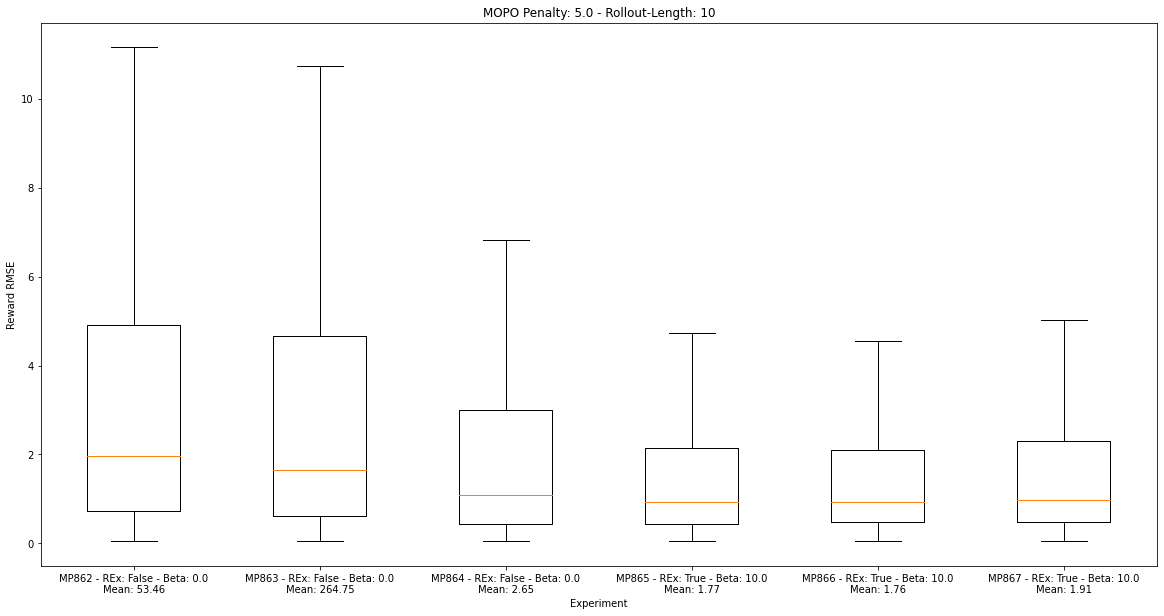

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

labels = []
rmse_arrs = []
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    rmse_vals = np.sqrt(training_results[exp].mse_results).flatten()
    labels.append(f'{exp} - REx: {rex} - Beta: {beta}\nMean: {np.nanmean(rmse_vals):.2f}')

    rmse_vals = np.nan_to_num(rmse_vals, nan=1e6)
    rmse_arrs.append(rmse_vals)

ax.boxplot(rmse_arrs, showmeans=False, showfliers=False, labels=labels)

ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Experiment')
ax.set_ylabel('Overall RMSE')
# ax.set_ylim(-0.01,0.35)

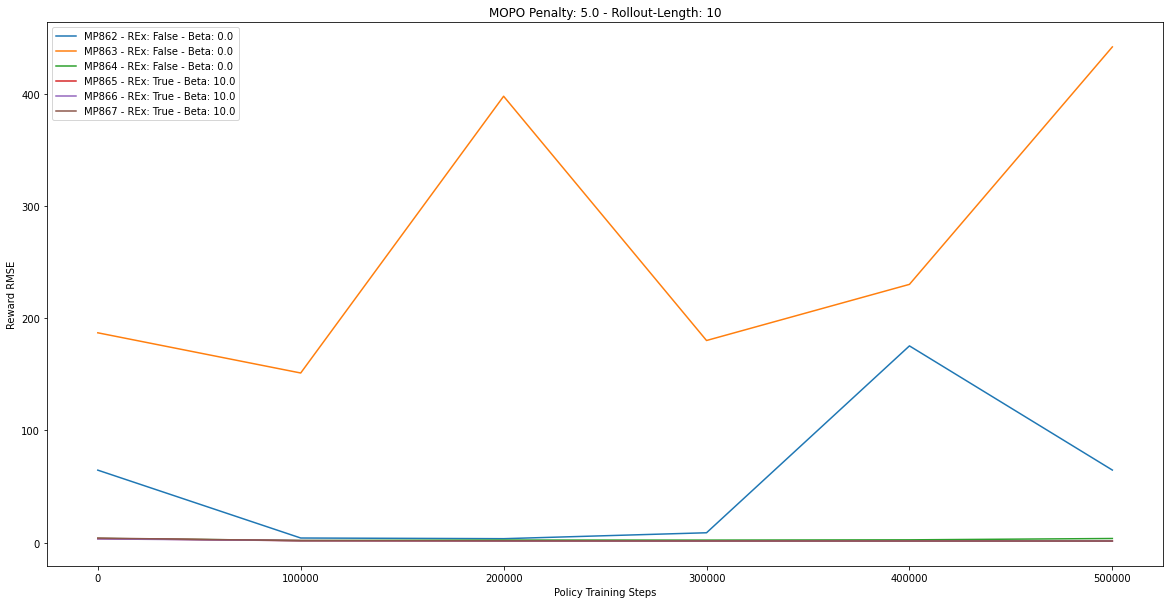

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    rmse_means = []
    for j, pool_id in enumerate(range(0,600000,100000)):
        _, _, _, mse_results, _ = get_sac_pools(exp, pool=str(pool_id), subsample_size=None)
        rmse_vals = np.sqrt(mse_results).flatten()
        rmse_means.append(np.nanmean(rmse_vals))
    
    label = f'{exp} - REx: {rex} - Beta: {beta}'
    ax.plot(rmse_means, label=label)

ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Policy Training Steps')
ax.set_ylabel('Overall RMSE')
ax.set_xticks(range(6))
ax.set_xticklabels(range(0,600000,100000))
# ax.set_ylim(-0.01,0.5)
ax.legend()

# Penalty/Reward RMSE Calibration

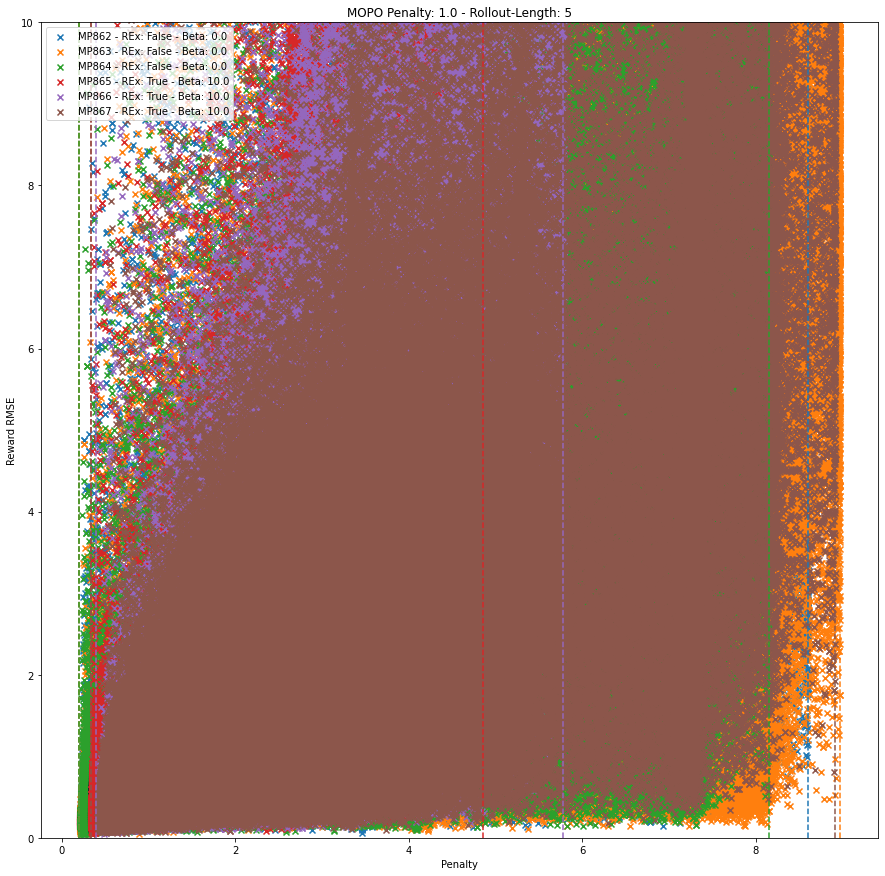

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, _, _, _, pens = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    ax.scatter(pens, np.sqrt(training_results[exp].mse_results), marker='x', color=cols[i], label=f'{exp} - REx: {rex} - Beta: {beta}')
    ax.axvline(exp_details.min_penalty, color=cols[i], ls='--')
    ax.axvline(exp_details.max_penalty, color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 1.0 - Rollout-Length: 5')
ax.set_xlabel('Penalty')
ax.set_ylabel('Reward RMSE')
ax.set_ylim(0, 10)
ax.legend(loc='upper left')

In [11]:
from sklearn.linear_model import LinearRegression

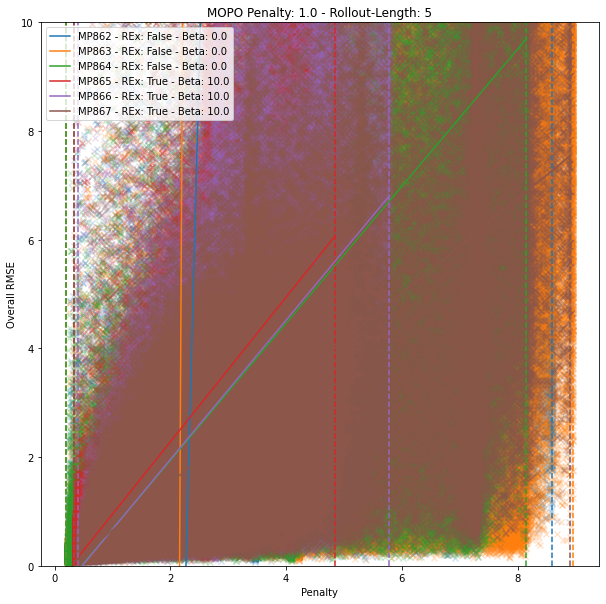

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, _, _, _, pens = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    mse_results = np.sqrt(training_results[exp].mse_results)

    nan_filter = np.isnan(mse_results.flatten())
    pens = pens.flatten()[~nan_filter][:,None]
    mse_results = mse_results.flatten()[~nan_filter][:,None]

    # pens = pens/(pens.max()-pens.min())
    # mse_results = mse_results/(mse_results.max()-pens.min())

    ax.scatter(pens, mse_results, marker='x', color=cols[i], alpha=0.2)

    reg = LinearRegression().fit(pens, mse_results)
    x_vals = np.linspace(exp_details.min_penalty, exp_details.max_penalty)[:,None]
    y_vals = reg.predict(x_vals)

    ax.plot(x_vals, y_vals, label=f'{exp} - REx: {rex} - Beta: {beta}')

    ax.axvline(exp_details.min_penalty, color=cols[i], ls='--')
    ax.axvline(exp_details.max_penalty, color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 1.0 - Rollout-Length: 5')
ax.set_xlabel('Penalty')
ax.set_ylabel('Overall RMSE')
ax.set_ylim(0, 10)
ax.legend(loc='upper left')

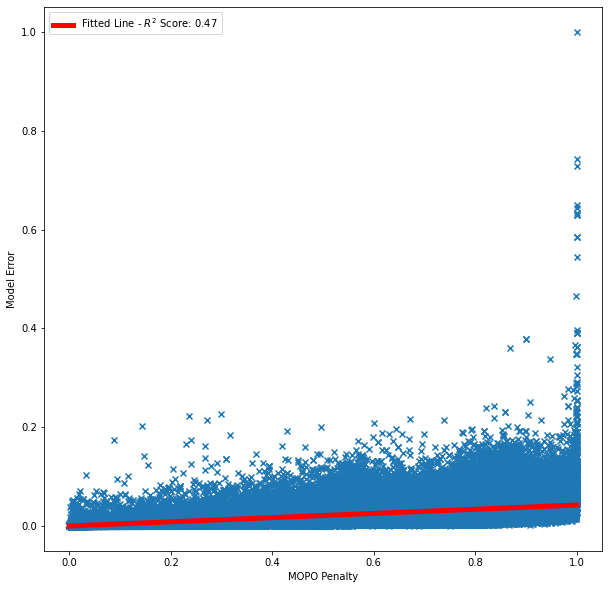

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP865", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, _, _, _, pens = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    mse_results = np.sqrt(training_results[exp].mse_results)

    nan_filter = np.isnan(mse_results.flatten())
    pens = pens.flatten()[~nan_filter][:,None]
    mse_results = mse_results.flatten()[~nan_filter][:,None]

    large_val_filter = mse_results.flatten() < 1e4
    pens = pens.flatten()[large_val_filter][:,None]
    mse_results = mse_results.flatten()[large_val_filter][:,None]

    pens = (pens-pens.min())/(pens.max()-pens.min())
    mse_results = (mse_results-mse_results.min())/(mse_results.max()-mse_results.min())

    ax.scatter(pens, mse_results, marker='x', color=cols[i])

    reg = LinearRegression().fit(pens, mse_results)
    x_vals = np.linspace(0,1)[:,None]
    y_vals = reg.predict(x_vals)

    ax.plot(x_vals, y_vals, c='red', linewidth=5.0, label=f'Fitted Line - $R^2$ Score: {reg.score(pens, mse_results):.2f}')

    # ax.axvline(exp_details.min_penalty/(pens.max()-pens.min()), color='k', ls='--')
    # ax.axvline(exp_details.max_penalty/(pens.max()-pens.min()), color='k', ls='--')
# ax.set_title('MOPO Penalty: 1.0 - Rollout-Length: 5')
ax.set_xlabel('MOPO Penalty')
ax.set_ylabel('Model Error')
# ax.set_ylim(0, 10)
ax.legend(loc='upper left')

# fig.savefig(os.path.join(FIG_DIR, 'ch6', 'novice_mopo_penalty_model_error.png'), pad_inches=0.2, bbox_inches='tight')

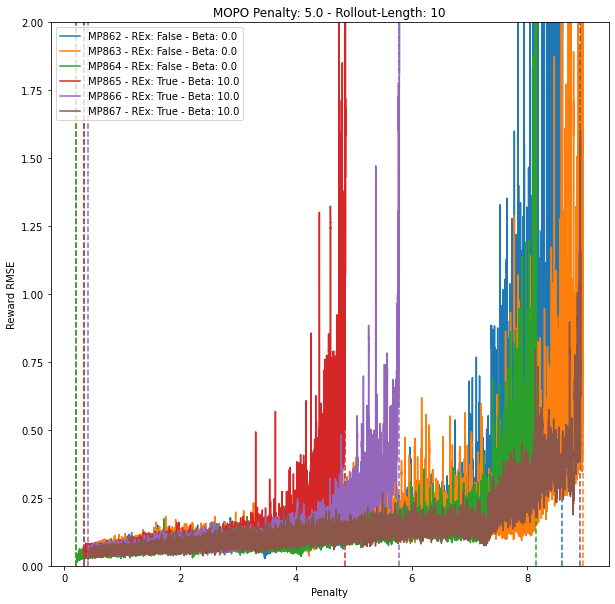

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, _, _, _, pens = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    pen_vals, rmse_err_vals = pens.flatten(), np.sqrt(training_results[exp].mse_results).flatten()
    arg_sort_ind = np.argsort(pen_vals)
    pen_vals, rmse_err_vals = pen_vals[arg_sort_ind], rmse_err_vals[arg_sort_ind]
    
    kernel_size = 50
    kernel = np.ones(kernel_size) / kernel_size
    rmse_err_convolved = np.convolve(rmse_err_vals, kernel, mode='same')

    ax.plot(pen_vals, rmse_err_convolved, color=cols[i], label=f'{exp} - REx: {rex} - Beta: {beta}')
    ax.axvline(exp_details.min_penalty, color=cols[i], ls='--')
    ax.axvline(exp_details.max_penalty, color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Penalty')
ax.set_ylabel('Reward RMSE')
ax.set_ylim(0, 2)
ax.legend(loc='upper left')

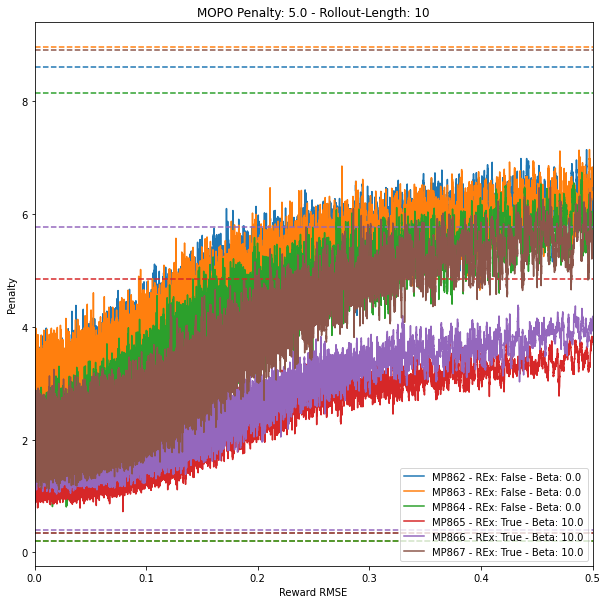

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, _, _, _, pens = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    pen_vals, rmse_err_vals = pens.flatten(), np.sqrt(training_results[exp].mse_results).flatten()
    arg_sort_ind = np.argsort(rmse_err_vals)
    pen_vals, rmse_err_vals = pen_vals[arg_sort_ind], rmse_err_vals[arg_sort_ind]
    
    kernel_size = 50
    kernel = np.ones(kernel_size) / kernel_size
    pen_convolved = np.convolve(pen_vals, kernel, mode='same')

    ax.plot(rmse_err_vals, pen_convolved, color=cols[i], label=f'{exp} - REx: {rex} - Beta: {beta}')
    ax.axhline(exp_details.min_penalty, color=cols[i], ls='--')
    ax.axhline(exp_details.max_penalty, color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Reward RMSE')
ax.set_ylabel('Penalty')
ax.set_xlim(0, 0.5)
ax.legend(loc='lower right')

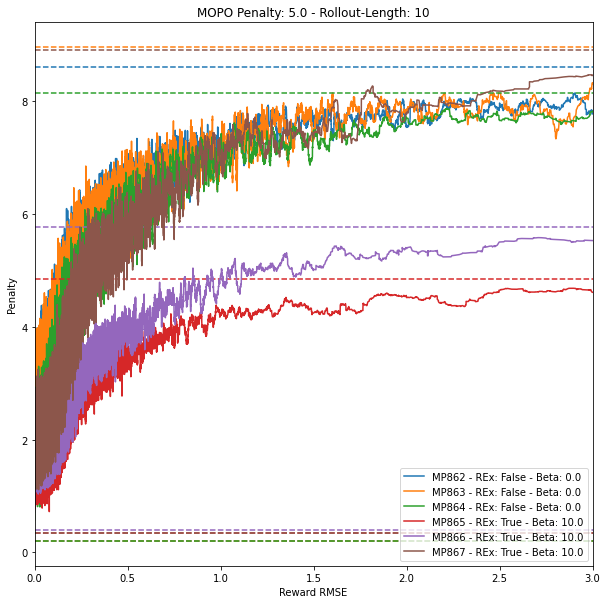

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, _, _, _, pens = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    pen_vals, rmse_err_vals = pens.flatten(), np.sqrt(training_results[exp].mse_results).flatten()
    arg_sort_ind = np.argsort(rmse_err_vals)
    pen_vals, rmse_err_vals = pen_vals[arg_sort_ind], rmse_err_vals[arg_sort_ind]
    
    kernel_size = 50
    kernel = np.ones(kernel_size) / kernel_size
    pen_convolved = np.convolve(pen_vals, kernel, mode='same')

    ax.plot(rmse_err_vals, pen_convolved, color=cols[i], label=f'{exp} - REx: {rex} - Beta: {beta}')
    ax.axhline(exp_details.min_penalty, color=cols[i], ls='--')
    ax.axhline(exp_details.max_penalty, color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Reward RMSE')
ax.set_ylabel('Penalty')
ax.set_xlim(0, 3)
ax.legend(loc='lower right')

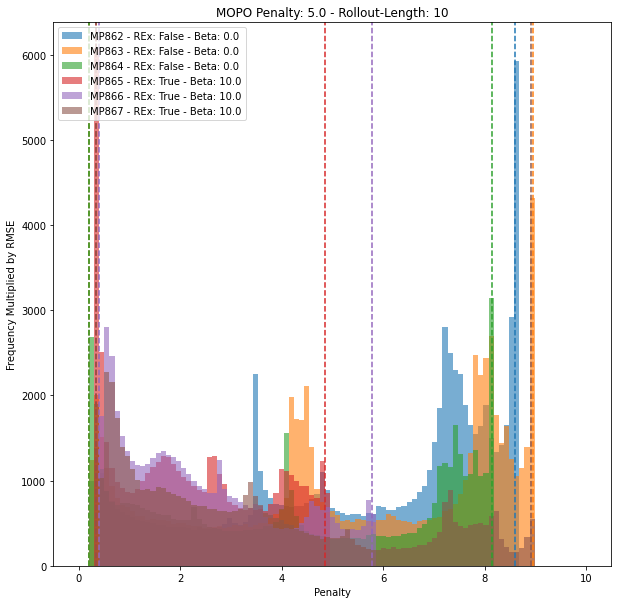

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, _, _, _, pens = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    rmse_vals = np.sqrt(training_results[exp].mse_results).flatten()
    rmse_lim = rmse_vals < 15
    ax.hist(pens.flatten()[rmse_lim], weights=rmse_vals[rmse_lim], bins=np.linspace(0,10,100), color=cols[i], alpha=0.6, label=f'{exp} - REx: {rex} - Beta: {beta}')
    ax.axvline(exp_details.min_penalty, color=cols[i], ls='--')
    ax.axvline(exp_details.max_penalty, color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Penalty')
ax.set_ylabel('Frequency Multiplied by RMSE')
ax.legend(loc='upper left')

# Reward/Reward RMSE

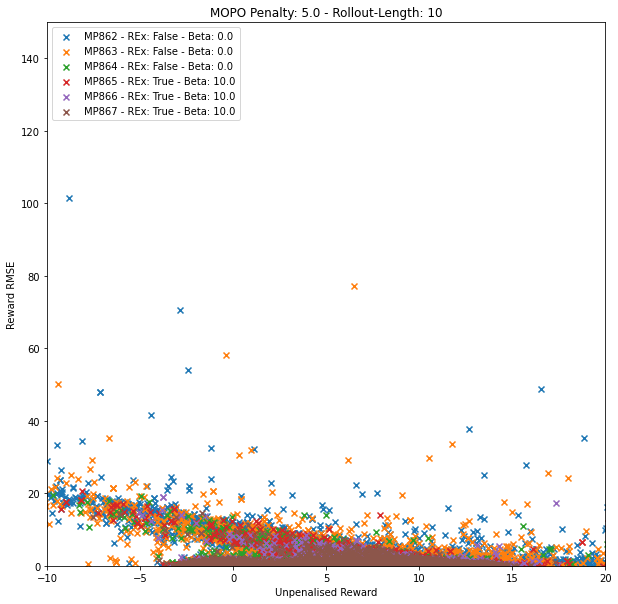

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, rew, _, _, pen = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    ax.scatter(rew+5*pen, np.sqrt(training_results[exp].mse_results), marker='x', color=cols[i], label=f'{exp} - REx: {rex} - Beta: {beta}')
    # ax.axvline(exp_details.max_penalty, color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Unpenalised Reward')
ax.set_ylabel('Reward RMSE')
ax.set_xlim(-10, 20)
ax.set_ylim(0, 150)
ax.legend(loc='upper left')

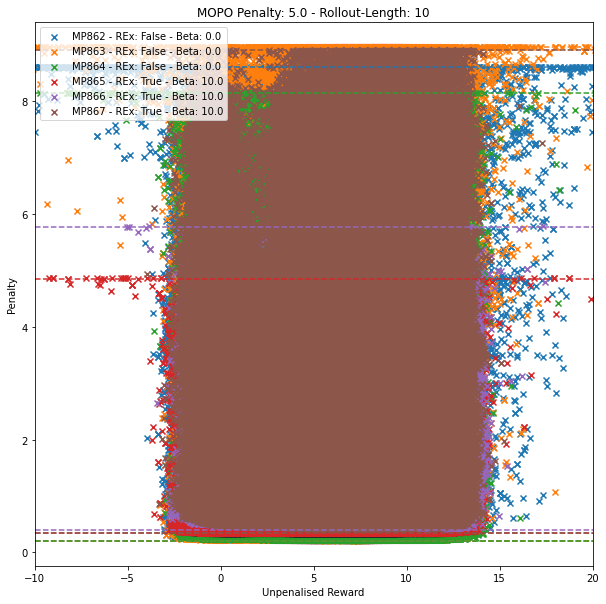

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, (exp, rex, beta) in enumerate([
    ("MP862", False, 0.0),
    ("MP863", False, 0.0),
    ("MP864", False, 0.0),
    ("MP865", True, 10.0),
    ("MP866", True, 10.0),
    ("MP867", True, 10.0),
]):
    exp_details = get_experiment_details(exp)
    _, _, _, rew, _, _, pen = split_halfcheetah_v2_trans_arr(training_results[exp].pool)
    ax.scatter(rew+5*pen, pen, marker='x', color=cols[i], label=f'{exp} - REx: {rex} - Beta: {beta}')
    ax.axhline(exp_details.min_penalty, color=cols[i], ls='--')
    ax.axhline(exp_details.max_penalty, color=cols[i], ls='--')
ax.set_title('MOPO Penalty: 5.0 - Rollout-Length: 10')
ax.set_xlabel('Unpenalised Reward')
ax.set_ylabel('Penalty')
ax.set_xlim(-10, 20)
# ax.set_ylim(0, 40)
ax.legend(loc='upper left')